In [1]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng
from math import ceil, log
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
# encoder = AngleEncoder(num_qubits=4)

In [2]:
class CustomEncoder(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)

        x = ParameterVector(param_prefix, num)
        enc = QuantumCircuit(num)
        for j in range(reps):
            for i in range(num):
                enc.ry(x[i], i)
        
        self.compose(enc, inplace=True)

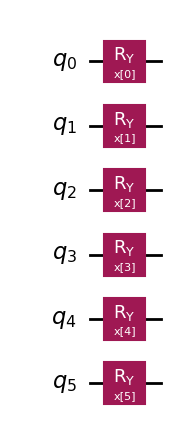

In [3]:
encoder =CustomEncoder(6, reps = 1)
encoder.draw("mpl")

In [6]:
class CustomAnsatz(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num_qubits, reps, param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits)
        qc = QuantumCircuit(num_qubits)
        for j in range(reps):
            for i in range(num_qubits):
                # for k in range(1,4):
                qc.ry(theta[(i)], i)
                    # qc.ry(theta[(i)*3 + 1], i) 
                    # qc.rz(theta[(i)*3 + 2], i) 

            for i in range(num_qubits-1):
                qc.cx(i, i+1)

            # qc.cx(num_qubits-1, 0)
            qc.barrier()
                    
        self.compose(qc, inplace=True)


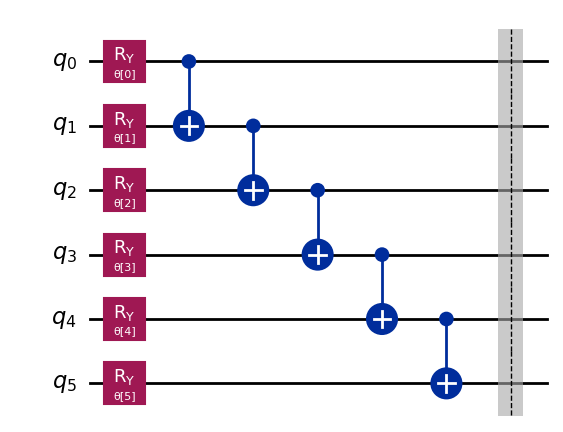

In [7]:
ansatz = CustomAnsatz(num_qubits=6, reps=1)
ansatz.draw("mpl")

In [8]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
def feature_creation(n):
    return [SparsePauliOp(["Z" + "Z"*(n-1)])]
            # SparsePauliOp(["I"*(n-1) + "Y"]), 
            # SparsePauliOp(["I"*(n-1)  + "Z"])]

quantum_features = feature_creation(6)

In [9]:
quantum_features

[SparsePauliOp(['ZZZZZZ'],
               coeffs=[1.+0.j])]

In [10]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features);

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01717 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.09203 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.14949 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.01431 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.06485 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.13018 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutationAnalysis - 0.35334 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.24819 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Collect2qBlocks - 0.07296 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.59104 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.05698 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00978 (ms)
INFO:qiskit.passm

In [11]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

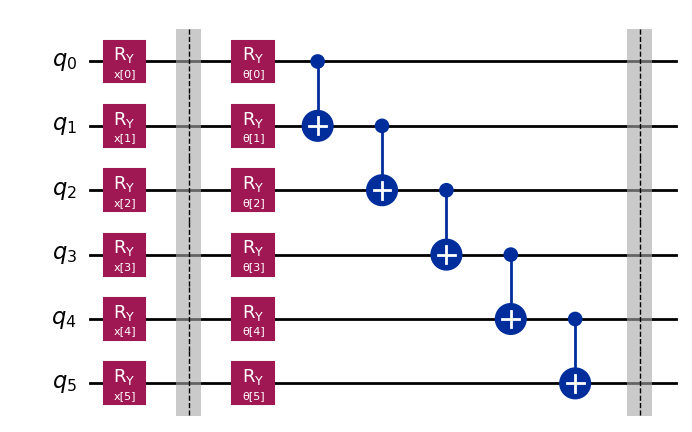

In [12]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

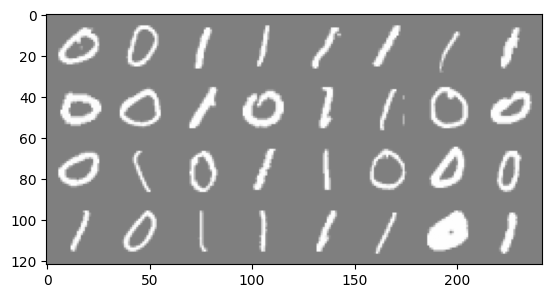

In [13]:
# Verify the images loaded correctly
classifier.visualize_batch()

In [14]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

train_set

CPU times: user 243 ms, sys: 82.3 ms, total: 325 ms
Wall time: 251 ms


Dataset MNIST
    Number of datapoints: 300
    Root location: ./mnist-train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [15]:
train_set[0][0].shape

torch.Size([1, 28, 6])

In [16]:
# Configure model training hyper parameters
config = {
    "epochs": 10,
    "lr": 0.1,
    "batch_size": 50,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

epoch:   1 | loss: 0.689
lr: 0.1000 | processed     6/    6 batches per epoch in 69.61s (0.67s forward / 9.83s backward)
Model achieved 57.667%  accuracy on TRAIN set.
Model achieved 55.000%  accuracy on TEST set.

epoch:   2 | loss: 0.685
lr: 0.1000 | processed     6/    6 batches per epoch in 69.29s (0.61s forward / 10.19s backward)
Model achieved 57.667%  accuracy on TRAIN set.
Model achieved 55.000%  accuracy on TEST set.

epoch:   3 | loss: 0.682
lr: 0.1000 | processed     6/    6 batches per epoch in 68.33s (0.59s forward / 9.89s backward)
Model achieved 57.667%  accuracy on TRAIN set.
Model achieved 55.000%  accuracy on TEST set.

epoch:   4 | loss: 0.681
lr: 0.1000 | processed     6/    6 batches per epoch in 68.46s (0.58s forward / 10.29s backward)
Model achieved 57.667%  accuracy on TRAIN set.
Model achieved 55.000%  accuracy on TEST set.



KeyboardInterrupt: 

In [ ]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

In [ ]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

In [ ]:
client.await_autograder_result(submission_id=submission_id)